# imports & catalogues

In [67]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.table import Table
from astropy.table import join
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.coordinates import SkyCoord
from scipy.optimize import linear_sum_assignment
import Code.all_fctns as all_fctns
import os
import scipy as sp
import plot_tools
import EW_tools
from dr_tools.sami_fluxcal import sami_read_apspec

SAMI_Target_catalogues = ("InputCatGAMADR3.fits", "InputCatClustersDR3.fits", "InputCatFiller.fits")
SAMI_regions = {0: "GAMA", 1: "Clusters", 2: "Filler"}

Source_dir ="C:\\Users\\mspan\\OneDrive - The University of Sydney (Students)\\Honours\\Honours Project\\"
catalogue_filepath = Source_dir + "Catalogues\\"
SAMI_regions = ("Cluster", "Filler", "GAMA")
SAMI_spectra_catalogue = "EmissionLine1compDR3.fits"
SAMI_SFR_catalogue = "AR2022_SAMI_DR3_Mstar_SFR_GSWL_rescaled.fits"
SAMI_AGN_summary_catalogue = "Crossmatched\\SAMI_AGN_matches.fits"
SAMI_cubeobs_catalogue = "CubeObs.fits"

shared_catalogue_filepath = Source_dir +  "SAMI_TOOLS_SMC_MSPA4681\\shared_catalogues\\"
gassig_statistics_catalogue = "gassig_statistics.fits"

def refresh_module():
    import importlib
    import Code.all_fctns as all_fctns
    import EW_tools
    importlib.reload(EW_tools)
    importlib.reload(all_fctns)
    importlib.reload(plot_tools)

ifs_path = Source_dir + "sami_tools_smc_mspa4681\\some_sample_ifs\\"

CATIDs = 40916, 9011900711, 298590, 6821

# plotting spectra

[6427.819 6492.819] [6632.819 6697.819]
Region 1 flux: 0.93 +/- 0.02


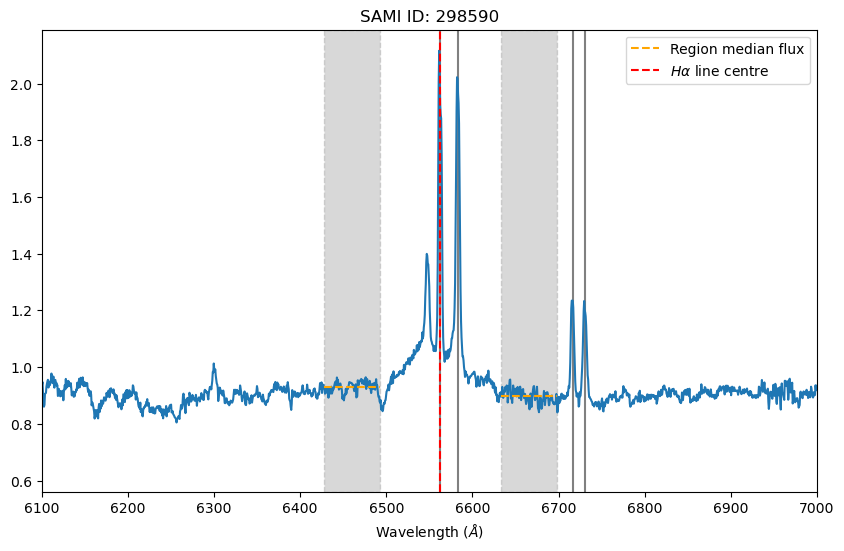

In [36]:
refresh_module()
CATIDs = 40916, 9011900711, 298590, 6821
CATID = CATIDs[2]

fig, ax = plt.subplots(1,1, figsize=(10,6))

def get_redshift_corrected_spectra(CATID, ifs_path=ifs_path):
    apspecfile_red = os.path.join(ifs_path,str(CATID), str(CATID)+'_A_spectrum_1-4-arcsec_red.fits')
    hdulist = fits.open(apspecfile_red)
    sami_flux_red,sami_lam_red = sami_read_apspec(hdulist,0,doareacorr=False)
    hdulist.close()
    redshift = all_fctns.get_z_best(catalogue_filepath, [CATID], only_spec=True)
    sami_lam_red_zcorr = sami_lam_red / (1 + redshift)
    return sami_flux_red, sami_lam_red_zcorr

sami_flux_red, sami_lam_red_zcorr = get_redshift_corrected_spectra(CATID)
ax.plot(sami_lam_red_zcorr, sami_flux_red)
plot_tools.plot_line_lam(ax, z=0, annotations=False)
ax.set_title(f"SAMI ID: {CATID}")
ax.set_xlabel(r"Wavelength ($\AA$)")
ax.set_xlim(6100,7000)


# set regions for collecting continuum flux symmetric about 6562
region_width = 65
region_separation = 140
Ha_lam = 6562.819
region1 = np.array([-region_width, 0]) + Ha_lam - region_separation/2  
region2 = np.array([0, region_width]) + Ha_lam + region_separation/2  
print(region1, region2)

# plot these regions
ax.axvspan(region1[0], region1[1], color='grey', alpha=0.3, linestyle='--')
ax.axvspan(region2[0], region2[1], color='grey', alpha=0.3, linestyle='--')




def get_spectra_region_flux(sami_lam, sami_flux, region, estimation_method='median'):
    """Get the mean flux in a given wavelength region."""
    region_mask = (sami_lam >= region[0]) & (sami_lam <= region[1])
    region_flux = np.mean(sami_flux[region_mask])
    region_flux_err = np.std(sami_flux[region_mask]) # check this
    return region_flux, region_flux_err

region1_flux, region1_flux_err = get_spectra_region_flux(sami_lam_red_zcorr, sami_flux_red, region1)
region2_flux, region2_flux_err = get_spectra_region_flux(sami_lam_red_zcorr, sami_flux_red, region2)
print(f"Region 1 flux: {region1_flux:.2f} +/- {region1_flux_err:.2f}")

ax.plot(region1, [region1_flux]*2, color='orange', linestyle='--', label='Region median flux')
ax.plot(region2, [region2_flux]*2, color='orange', linestyle='--')

ax.axvline(Ha_lam, color='red', linestyle='--', label='$H\\alpha$ line centre')
ax.legend()


[6427.819 6492.819] [6632.819 6697.819]
Region 1 flux: 0.20 +/- 0.01


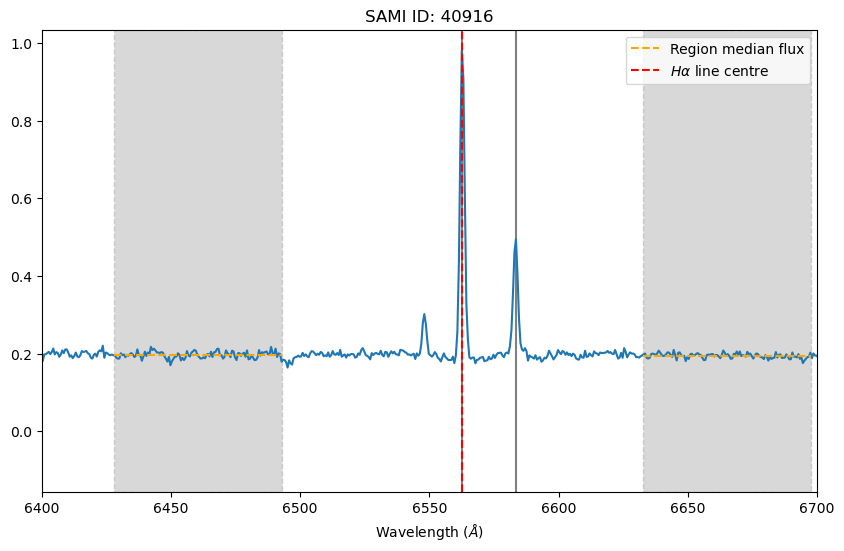

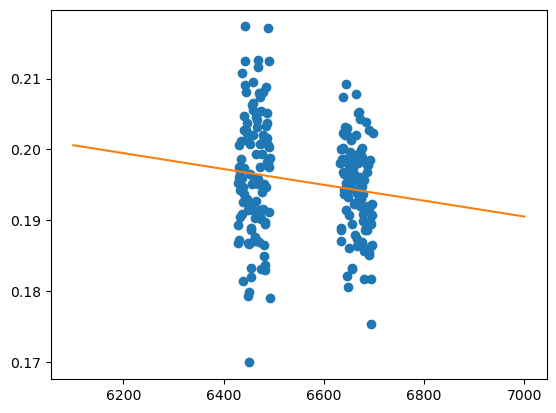

In [8]:
refresh_module()
CATID = CATIDs[0]

fig, ax = plt.subplots(1,1, figsize=(10,6))

sami_flux_red, sami_lam_red_zcorr = get_redshift_corrected_spectra(CATID)
ax.plot(sami_lam_red_zcorr, sami_flux_red)
plot_tools.plot_line_lam(ax, z=0, annotations=False)
ax.set_title(f"SAMI ID: {CATID}")
ax.set_xlabel(r"Wavelength ($\AA$)")
ax.set_xlim(6100,7000)


# set regions for collecting continuum flux symmetric about 6562
region_width = 65
region_separation = 140
Ha_lam = 6562.819
region1 = np.array([-region_width, 0]) + Ha_lam - region_separation/2  
region2 = np.array([0, region_width]) + Ha_lam + region_separation/2  
print(region1, region2)

# plot these regions
ax.axvspan(region1[0], region1[1], color='grey', alpha=0.3, linestyle='--')
ax.axvspan(region2[0], region2[1], color='grey', alpha=0.3, linestyle='--')


def get_spectra_region_flux(sami_lam, sami_flux, region, estimation_method='median'):
    """Get the mean flux in a given wavelength region."""
    region_mask = (sami_lam >= region[0]) & (sami_lam <= region[1])
    region_flux = np.mean(sami_flux[region_mask])
    region_flux_err = np.std(sami_flux[region_mask]) # check this
    return region_flux, region_flux_err

region1_flux, region1_flux_err = get_spectra_region_flux(sami_lam_red_zcorr, sami_flux_red, region1)
region2_flux, region2_flux_err = get_spectra_region_flux(sami_lam_red_zcorr, sami_flux_red, region2)
print(f"Region 1 flux: {region1_flux:.2f} +/- {region1_flux_err:.2f}")

ax.plot(region1, [region1_flux]*2, color='orange', linestyle='--', label='Region median flux')
ax.plot(region2, [region2_flux]*2, color='orange', linestyle='--')

ax.axvline(Ha_lam, color='red', linestyle='--', label='$H\\alpha$ line centre')
ax.legend()

ax.set_xlim(6400, 6700)

plt.show()

plt.figure()

region_width = 65
region_separation = 140
Ha_lam = 6562.819
region1 = np.array([-region_width, 0]) + Ha_lam - region_separation/2  
region2 = np.array([0, region_width]) + Ha_lam + region_separation/2  
regions = (region1, region2)

# get the relevant points for line fitting
regions_mask = (sami_lam_red_zcorr >= regions[0][0]) & (sami_lam_red_zcorr <= regions[0][1]) | (sami_lam_red_zcorr >= regions[1][0]) & (sami_lam_red_zcorr <= regions[1][1])
regions_sami_lam_red_zcorr = sami_lam_red_zcorr[regions_mask]
regions_sami_flux_red = sami_flux_red[regions_mask]

plt.plot(regions_sami_lam_red_zcorr, regions_sami_flux_red, 'o')

# fit a line to these points
res = sp.stats.linregress(regions_sami_lam_red_zcorr, regions_sami_flux_red)
slope, intercept, slope_err, intercept_err = res.slope, res.intercept, res.stderr, res.intercept_stderr
continuum_flux = slope*Ha_lam + intercept
continuum_flux_err = np.sqrt( (slope_err*Ha_lam)**2 + intercept_err**2 )
lambda_fit = np.linspace(6100, 7000, 1000)
plt.plot(lambda_fit, slope*lambda_fit + intercept, label='Linear fit to continuum regions')

In [26]:
refresh_module()
print(ifs_path)
EW_tools.get_EW_table(CATIDs, ifs_path=ifs_path, catalogue_filepath=catalogue_filepath)


C:\Users\mspan\OneDrive - The University of Sydney (Students)\Honours\Honours Project\sami_tools_smc_mspa4681\some_sample_ifs\
Continuum flux at Halpha: 0.19555682001757158 +/- 0.010906330007173462
[1.98538995]
Continuum flux at Halpha: 0.19540965441991598 +/- 0.0461180634141325
[1.98538995]
Continuum flux at Halpha: 0.7383007384762741 +/- 0.02424430256959412
[0.01206643]
Continuum flux at Halpha: 0.7403747462554662 +/- 0.10343987717365835
[0.01206643]
Continuum flux at Halpha: 0.9142593759410572 +/- 0.03023169490669929
[7.64159489]
Continuum flux at Halpha: 0.9131849316252659 +/- 0.12467274674697548
[7.64159489]
Continuum flux at Halpha: 0.13328371522619287 +/- 0.06886815329459547
[100.47062683]
Continuum flux at Halpha: 0.14028360374327378 +/- 0.2895809985234365
[100.47062683]


CATID,H_Alpha_EW_MedianFit,H_Alpha_EW_err_MedianFit,H_Alpha_EW_LineFit,H_Alpha_EW_err_LineFit
int64,float64,float64,float64,float64
40916,10.152496587502498,0.5751340684389937,10.160142567085396,2.3999914642170133
9011900711,0.01634351412744184,0.03656297964581625,0.016297731129559904,0.03652766705403445
298590,8.358235187814408,0.2831222157971041,8.368069404276577,1.1441057578990552
6821,753.8102210052308,389.5251689243251,716.1965058647987,1478.4184035514984


In [45]:
with fits.open(catalogue_filepath + SAMI_spectra_catalogue) as SAMI_spectra_hdul:
    SAMI_spectra_table_hdu = Table(SAMI_spectra_hdul[1].data)

CATID = 15165
SAMI_spectra_table_hdu[SAMI_spectra_table_hdu['CATID'] == CATID]['HALPHA_1_4_ARCSECOND']

1.5370374
0.9380064


# WHaN plot

['CATID', 'HAlpha_EW_MedianFit', 'HAlpha_EW_err_MedianFit', 'HAlpha_EW_LineFit', 'HAlpha_EW_err_LineFit']


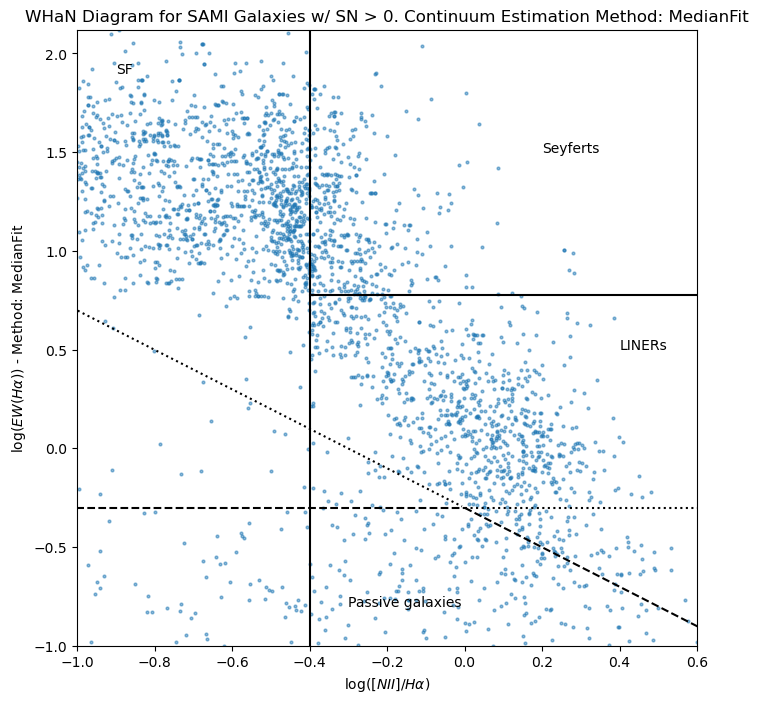

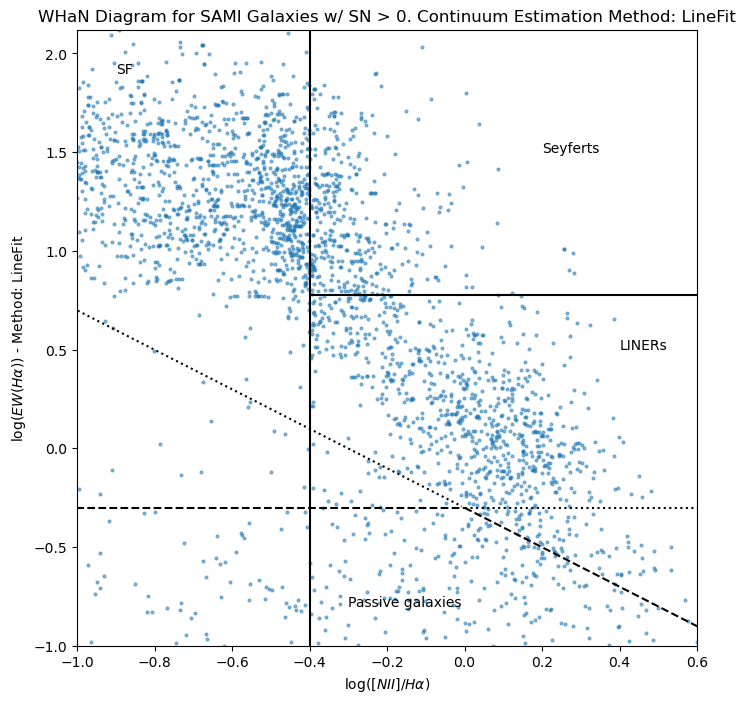

In [ ]:
def plot_WHAN_lines(ax, paper='Cid Fernandes et al. (2011)', region_labels=True, fontsize=15):
    xrange = ax.get_xlim()
    yrange = ax.get_ylim()

    xs = np.linspace(xrange[0], xrange[1], 1000)

    if paper == 'Cid Fernandes et al. (2011)':
        m_line = (np.log10(5)-np.log10(0.5))/(-1-0)
        c_line = np.log10(0.5)

        # uncertain lines
        ax.plot(xs[xs<0], m_line*xs[xs<0] + c_line, 'k:')
        ax.plot([0, xrange[1]], [np.log10(0.5)]*2, 'k:')

        # passive galaxy lines
        ax.plot(xs[xs>0], m_line*xs[xs>0] + c_line, 'k--')
        ax.plot([xrange[0], 0], [np.log10(0.5)]*2, 'k--')

        ax.plot([-0.4, xrange[1]], [np.log10(6)]*2, color='k') # K06 Seyfert/LINER line
        ax.axvline(-0.4, color='k') # S06 SF/AGN line

        if region_labels:
            ax.text(0.2, 1.5, 'Seyferts', size=fontsize)
            ax.text(0.4, 0.5, 'LINERs', size=fontsize)
            ax.text(-0.9, 1.9, 'SF', size=fontsize)
            ax.text(-0.3, -0.8, 'Passive galaxies', size=fontsize)


estimation_methods = ('MedianFit', 'LineFit')


with fits.open(shared_catalogue_filepath + "HAlpha_EW_Table.fits") as Ha_EW_hdul:
    Ha_EW_table = Table(Ha_EW_hdul[1].data)

print(Ha_EW_table.colnames)

with fits.open( os.path.join(catalogue_filepath, SAMI_spectra_catalogue) ) as SAMI_spectra_hdul:
    SAMI_spectra_table_hdu = Table(SAMI_spectra_hdul[1].data)


reduced_spectra_table = SAMI_spectra_table_hdu.copy()
reduced_spectra_table.keep_columns(['CATID', 'NII6583_1_4_ARCSECOND', 'NII6583_1_4_ARCSECOND_ERR', 'HALPHA_1_4_ARCSECOND', 'HALPHA_1_4_ARCSECOND_ERR'])

HA_EW_NII_HA_table = join(Ha_EW_table, reduced_spectra_table, keys='CATID', join_type='inner')

SN_lim=0
method = 'LineFit'


for method in estimation_methods:
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    SN_mask = (HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND'] / HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND_ERR'] > SN_lim) & (HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND'] / HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND_ERR'] > SN_lim) & (HA_EW_NII_HA_table[f'HAlpha_EW_{method}'] / HA_EW_NII_HA_table[f'HAlpha_EW_err_{method}'] > SN_lim)

    ax.plot(np.log10(HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND'][SN_mask] / HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND'][SN_mask]), np.log10(HA_EW_NII_HA_table[f'HAlpha_EW_{method}'][SN_mask]), 'o', markersize=2, alpha=0.5)

    ax.set_xlabel(r"$\log([NII]/H\alpha)$")
    ax.set_ylabel(r"$\log(EW(H\alpha))$" + f" - Method: {method}")

    ax.set_title(f"WHaN Diagram for SAMI Galaxies w/ SN > {SN_lim}. Continuum Estimation Method: {method}")

    plot_WHAN_lines(ax, fontsize=10)
    ax.set_xlim(-1, 0.6)
    ax.set_ylim(-1, 2.12)



## WHAN w/ BPT labels

In [35]:
BPT_values = (0,1,2,3,4,5,6,7,8,9,10,-1)
BPT_labels = ('HII', 'HII/Comp', 'Comp', 'AGN/Comp', 'HII/Comp/AGN', 'HII/AGN', 'LINER', 'Seyfert', 'Boundary AGN', 'AGN OIII', 'AGN - NII limit only', 'Inconclusive')
BPT_colors = ('red', 'orange', 'yellow', 'purple',      'magenta',     'pink',  'green', 'blue',    'cyan',         'blue',     'green',    'black')
BPT_marker = ('o',      'o',    'o',        'o',        'o',            'o',    'o',        'o',    'o',            's',        's',        'x')

full_BPT_classification_dict = {i: (label, color, marker) for i, label, color, marker in zip(BPT_values, BPT_labels, BPT_colors, BPT_marker)}

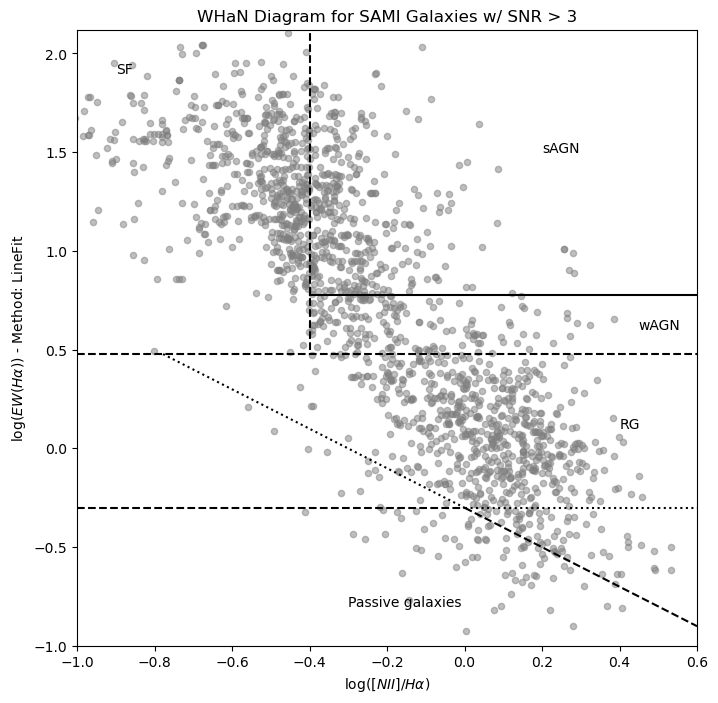

In [94]:
with fits.open(shared_catalogue_filepath + "HAlpha_EW_Table.fits") as Ha_EW_hdul:
    Ha_EW_table = Table(Ha_EW_hdul[1].data)

with fits.open( os.path.join(catalogue_filepath, SAMI_spectra_catalogue) ) as SAMI_spectra_hdul:
    SAMI_spectra_table_hdu = Table(SAMI_spectra_hdul[1].data)

with fits.open( os.path.join(shared_catalogue_filepath, "SAMI_AGN_matches.fits") ) as SAMI_AGN_matches_hdul:
    Summary_table_hdu = Table(SAMI_AGN_matches_hdul[1].data)


reduced_spectra_table = SAMI_spectra_table_hdu.copy()
reduced_spectra_table.keep_columns(['CATID', 'NII6583_1_4_ARCSECOND', 'NII6583_1_4_ARCSECOND_ERR', 'HALPHA_1_4_ARCSECOND', 'HALPHA_1_4_ARCSECOND_ERR'])
HA_EW_NII_HA_table = join(Ha_EW_table, reduced_spectra_table, keys='CATID', join_type='inner')
HA_EW_NII_HA_table = join(HA_EW_NII_HA_table, Summary_table_hdu['CATID', 'CATEGORY_BPT_AGN'], keys='CATID', join_type='left')

SN_lim=3
method = 'LineFit'

fig, ax = plt.subplots(1,1, figsize=(8,8))
SN_mask = ((HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND'] / HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND_ERR'] > SN_lim) 
           & (HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND'] / HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND_ERR'] > SN_lim) 
           & (HA_EW_NII_HA_table[f'H_Alpha_EW_{method}'] / HA_EW_NII_HA_table[f'H_Alpha_EW_err_{method}'] > SN_lim) )

ax.scatter(np.log10(HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND'][SN_mask] / HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND'][SN_mask]), 
           np.log10(HA_EW_NII_HA_table[f'H_Alpha_EW_{method}'][SN_mask]), 
           c='grey', marker='o', s=20, alpha=0.5, label='All galaxies with SN > 3')

# for bpt_value, (bpt_label, bpt_color, bpt_marker) in full_BPT_classification_dict.items():
#     bpt_mask = (HA_EW_NII_HA_table['CATEGORY_BPT_AGN'] == bpt_value) & SN_mask
#     if np.sum(bpt_mask) > 0:
#         ax.scatter(np.log10(HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND'][bpt_mask] / HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND'][bpt_mask]), 
#                    np.log10(HA_EW_NII_HA_table[f'H_Alpha_EW_{method}'][bpt_mask]), 
#                    c=bpt_color, marker=bpt_marker, s=20, alpha=0.5, label=bpt_label)

# ax.plot(np.log10(HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND'][SN_mask] / HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND'][SN_mask]), 
#         np.log10(HA_EW_NII_HA_table[f'H_Alpha_EW_{method}'][SN_mask]), markersize=2, alpha=0.5)

ax.set_xlabel(r"$\log([NII]/H\alpha)$")
ax.set_ylabel(r"$\log(EW(H\alpha))$" + f" - Method: {method}")

ax.set_title(f"WHaN Diagram for SAMI Galaxies w/ SNR > {SN_lim}")

ax.set_xlim(-1, 0.6)
ax.set_ylim(-1, 2.12)
refresh_module()
EW_tools.plot_WHAN_lines(ax, fontsize=10, paper='Fernandes (2011) - strong/weak')

# ax.legend(title='BPT Classification', loc='lower left')

plt.show()


c:\Users\mspan\OneDrive - The University of Sydney (Students)\Honours\Honours Project\sami_tools_smc_mspa4681\plot_tools.py:437: SyntaxWarning: invalid escape sequence '\A'
  


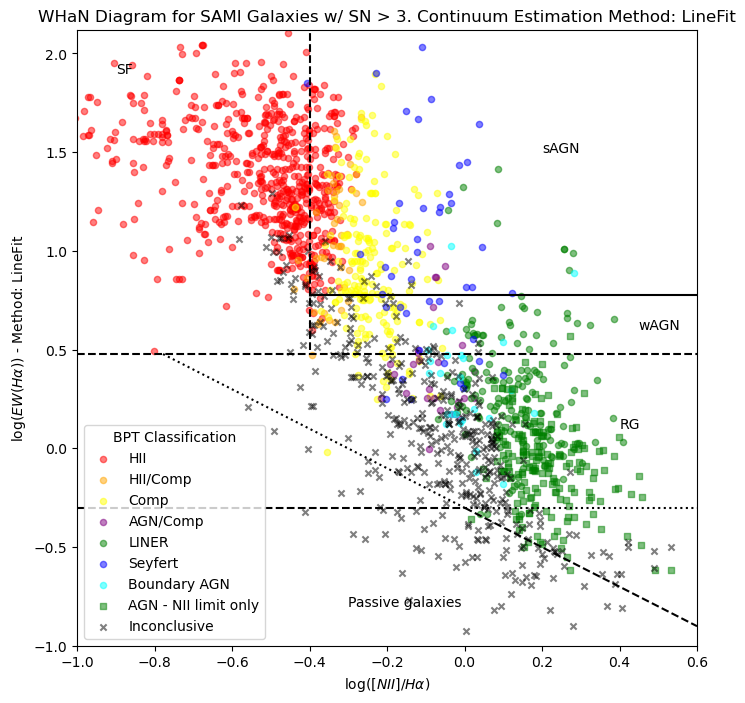

In [36]:
with fits.open(shared_catalogue_filepath + "HAlpha_EW_Table.fits") as Ha_EW_hdul:
    Ha_EW_table = Table(Ha_EW_hdul[1].data)

with fits.open( os.path.join(catalogue_filepath, SAMI_spectra_catalogue) ) as SAMI_spectra_hdul:
    SAMI_spectra_table_hdu = Table(SAMI_spectra_hdul[1].data)

with fits.open( os.path.join(shared_catalogue_filepath, "SAMI_AGN_matches.fits") ) as SAMI_AGN_matches_hdul:
    Summary_table_hdu = Table(SAMI_AGN_matches_hdul[1].data)


reduced_spectra_table = SAMI_spectra_table_hdu.copy()
reduced_spectra_table.keep_columns(['CATID', 'NII6583_1_4_ARCSECOND', 'NII6583_1_4_ARCSECOND_ERR', 'HALPHA_1_4_ARCSECOND', 'HALPHA_1_4_ARCSECOND_ERR'])
HA_EW_NII_HA_table = join(Ha_EW_table, reduced_spectra_table, keys='CATID', join_type='inner')
HA_EW_NII_HA_table = join(HA_EW_NII_HA_table, Summary_table_hdu['CATID', 'CATEGORY_BPT_AGN'], keys='CATID', join_type='left')

SN_lim=3
method = 'LineFit'

fig, ax = plt.subplots(1,1, figsize=(8,8))
SN_mask = ((HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND'] / HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND_ERR'] > SN_lim) 
           & (HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND'] / HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND_ERR'] > SN_lim) 
           & (HA_EW_NII_HA_table[f'H_Alpha_EW_{method}'] / HA_EW_NII_HA_table[f'H_Alpha_EW_err_{method}'] > SN_lim) )

for bpt_value, (bpt_label, bpt_color, bpt_marker) in full_BPT_classification_dict.items():
    bpt_mask = (HA_EW_NII_HA_table['CATEGORY_BPT_AGN'] == bpt_value) & SN_mask
    if np.sum(bpt_mask) > 0:
        ax.scatter(np.log10(HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND'][bpt_mask] / HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND'][bpt_mask]), 
                   np.log10(HA_EW_NII_HA_table[f'H_Alpha_EW_{method}'][bpt_mask]), 
                   c=bpt_color, marker=bpt_marker, s=20, alpha=0.5, label=bpt_label)

# ax.plot(np.log10(HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND'][SN_mask] / HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND'][SN_mask]), 
#         np.log10(HA_EW_NII_HA_table[f'H_Alpha_EW_{method}'][SN_mask]), markersize=2, alpha=0.5)

ax.set_xlabel(r"$\log([NII]/H\alpha)$")
ax.set_ylabel(r"$\log(EW(H\alpha))$" + f" - Method: {method}")

ax.set_title(f"WHaN Diagram for SAMI Galaxies w/ SN > {SN_lim}. Continuum Estimation Method: {method}")

ax.set_xlim(-1, 0.6)
ax.set_ylim(-1, 2.12)
refresh_module()
EW_tools.plot_WHAN_lines(ax, fontsize=10, paper='Fernandes (2011) - strong/weak')

ax.legend(title='BPT Classification', loc='lower left')

plt.show()


## Dispersion Colouring

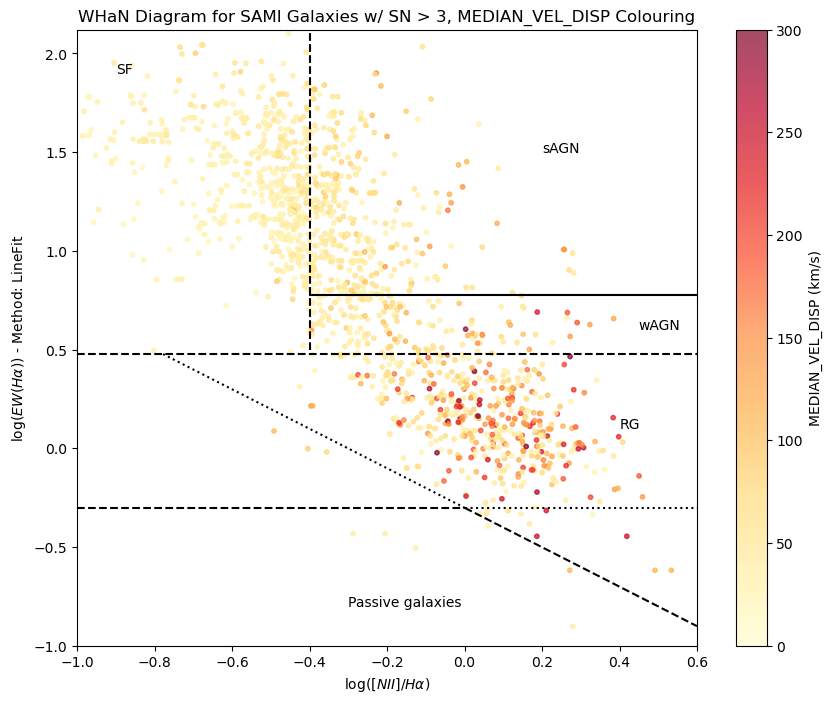

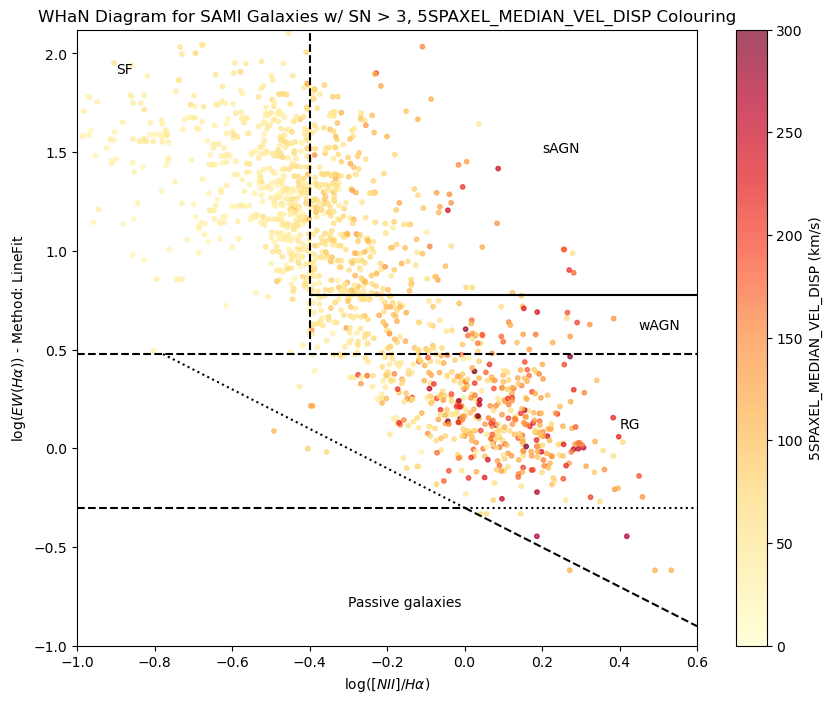

In [51]:
with fits.open(shared_catalogue_filepath + "HAlpha_EW_Table.fits") as Ha_EW_hdul:
    Ha_EW_table = Table(Ha_EW_hdul[1].data)

with fits.open( os.path.join(catalogue_filepath, SAMI_spectra_catalogue) ) as SAMI_spectra_hdul:
    SAMI_spectra_table_hdu = Table(SAMI_spectra_hdul[1].data)

with fits.open( os.path.join(shared_catalogue_filepath, "SAMI_AGN_matches.fits") ) as SAMI_AGN_matches_hdul:
    Summary_table_hdu = Table(SAMI_AGN_matches_hdul[1].data)

with fits.open( os.path.join(shared_catalogue_filepath, gassig_statistics_catalogue) ) as gassig_statistics_hdul:
    gassig_statistics_table_hdu = Table(gassig_statistics_hdul[1].data)


reduced_spectra_table = SAMI_spectra_table_hdu.copy()
reduced_spectra_table.keep_columns(['CATID', 'NII6583_1_4_ARCSECOND', 'NII6583_1_4_ARCSECOND_ERR', 'HALPHA_1_4_ARCSECOND', 'HALPHA_1_4_ARCSECOND_ERR'])
HA_EW_NII_HA_table = join(Ha_EW_table, reduced_spectra_table, keys='CATID', join_type='inner')
HA_EW_NII_HA_table = join(HA_EW_NII_HA_table, Summary_table_hdu['CATID', 'CATEGORY_BPT_AGN'], keys='CATID', join_type='left')

SN_lim=3
method = 'LineFit'

SN_mask = ((HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND'] / HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND_ERR'] > SN_lim) 
           & (HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND'] / HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND_ERR'] > SN_lim) 
           & (HA_EW_NII_HA_table[f'H_Alpha_EW_{method}'] / HA_EW_NII_HA_table[f'H_Alpha_EW_err_{method}'] > SN_lim) )


# to do colouring, join to the dispersion table

WHAN_dispersion_table = join(HA_EW_NII_HA_table, gassig_statistics_table_hdu, keys='CATID', join_type='left')

for gassig_statistic in ('MEDIAN_VEL_DISP', '5SPAXEL_MEDIAN_VEL_DISP'):

    fig, ax = plt.subplots(1,1, figsize=(10,8))
    ax.scatter(np.log10(WHAN_dispersion_table['NII6583_1_4_ARCSECOND'][SN_mask] / WHAN_dispersion_table['HALPHA_1_4_ARCSECOND'][SN_mask]), 
            np.log10(WHAN_dispersion_table[f'H_Alpha_EW_{method}'][SN_mask]),
            c=WHAN_dispersion_table[gassig_statistic][SN_mask], cmap=plt.cm.YlOrRd, marker='o', s=10, alpha=0.7, vmin=0, vmax=300)

    cbar = plt.colorbar(ax.collections[0], ax=ax)
    cbar.set_label(f'{gassig_statistic} (km/s)')

    # ax.plot(np.log10(HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND'][SN_mask] / HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND'][SN_mask]), 
    #         np.log10(HA_EW_NII_HA_table[f'HAlpha_EW_{method}'][SN_mask]), markersize=2, alpha=0.5)

    ax.set_xlabel(r"$\log([NII]/H\alpha)$")
    ax.set_ylabel(r"$\log(EW(H\alpha))$" + f" - Method: {method}")

    ax.set_title(f"WHaN Diagram for SAMI Galaxies w/ SN > {SN_lim}, {gassig_statistic} Colouring")

    ax.set_xlim(-1, 0.6)
    ax.set_ylim(-1, 2.12)
    refresh_module()
    EW_tools.plot_WHAN_lines(ax, fontsize=10, paper='Fernandes (2011) - strong/weak')

    # ax.legend(title='BPT Classification', loc='lower left')

    plt.show()

## RadioSource Colouring

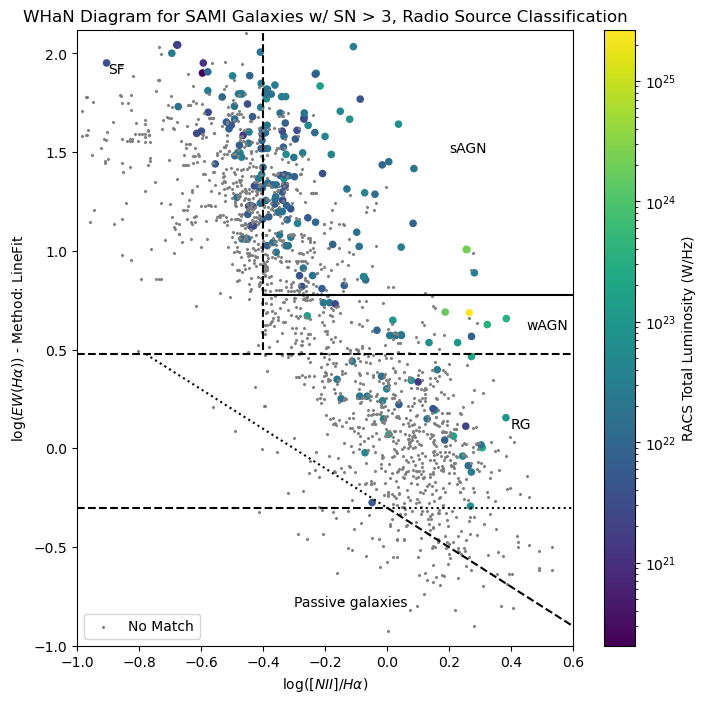

In [89]:
with fits.open(shared_catalogue_filepath + "HAlpha_EW_Table.fits") as Ha_EW_hdul:
    Ha_EW_table = Table(Ha_EW_hdul[1].data)

with fits.open( os.path.join(catalogue_filepath, SAMI_spectra_catalogue) ) as SAMI_spectra_hdul:
    SAMI_spectra_table_hdu = Table(SAMI_spectra_hdul[1].data)

with fits.open( os.path.join(shared_catalogue_filepath, "SAMI_AGN_matches.fits") ) as SAMI_AGN_matches_hdul:
    Summary_table_hdu = Table(SAMI_AGN_matches_hdul[1].data)

with fits.open( os.path.join(shared_catalogue_filepath, gassig_statistics_catalogue) ) as gassig_statistics_hdul:
    gassig_statistics_table_hdu = Table(gassig_statistics_hdul[1].data)


reduced_spectra_table = SAMI_spectra_table_hdu.copy()
reduced_spectra_table.keep_columns(['CATID', 'NII6583_1_4_ARCSECOND', 'NII6583_1_4_ARCSECOND_ERR', 'HALPHA_1_4_ARCSECOND', 'HALPHA_1_4_ARCSECOND_ERR'])
HA_EW_NII_HA_table = join(Ha_EW_table, reduced_spectra_table, keys='CATID', join_type='inner')
HA_EW_NII_HA_table = join(HA_EW_NII_HA_table, Summary_table_hdu['CATID', 'CATEGORY_BPT_AGN', 'IS_RADIOSOURCE', 'RACS_TOTALFLUX', 'RACS_TOTALFLUX_ERR', 'Z_SPEC'], keys='CATID', join_type='left')

SN_lim=3
method = 'LineFit'

SN_mask = ((HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND'] / HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND_ERR'] > SN_lim) 
           & (HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND'] / HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND_ERR'] > SN_lim) 
           & (HA_EW_NII_HA_table[f'H_Alpha_EW_{method}'] / HA_EW_NII_HA_table[f'H_Alpha_EW_err_{method}'] > SN_lim) )

radiosource_mask = HA_EW_NII_HA_table['IS_RADIOSOURCE'] == 1
radiosource_colour = 'blue'
nosource_marker = 'x'
nosource_colour = 'grey'

source_type_dict = {'Radio Source': (radiosource_mask, 'o', 20, radiosource_colour),
                    'No Match': ( ~radiosource_mask, nosource_marker , 2, nosource_colour),}

# source_type_dict_handles = {key: plt.Line2D([0], [0], marker=value[1], color='k', label=key, markersize=10, linestyle='None') for key, value in source_type_dict.items()} # for the legends


# radiosource_mask = HA_EW_NII_HA_table['IS_RADIOSOURCE'] == 1
# radio_classification_dict = {0: ('Non-Radio Source', 'black', 0.3) 1: ('Radio Source', }

# to do colouring, join to the dispersion table

WHAN_dispersion_table = join(HA_EW_NII_HA_table, gassig_statistics_table_hdu, keys='CATID', join_type='left')

luminosities = all_fctns.get_radio_luminosity(HA_EW_NII_HA_table, HA_EW_NII_HA_table['CATID'] )

fig, ax = plt.subplots(1,1, figsize=(8,8))

for source_type, (type_mask, type_marker, type_size, type_colour) in source_type_dict.items():
    combined_mask = type_mask & SN_mask

    # colouring by radio flux
    if source_type == 'Radio Source':
        ax.scatter(np.log10(WHAN_dispersion_table['NII6583_1_4_ARCSECOND'][combined_mask] / WHAN_dispersion_table['HALPHA_1_4_ARCSECOND'][combined_mask]), 
                np.log10(WHAN_dispersion_table[f'H_Alpha_EW_{method}'][combined_mask]),
                c=luminosities[combined_mask].value, cmap=plt.cm.viridis, marker=type_marker, s=type_size, alpha=1, norm=LogNorm())
        cbar = plt.colorbar(ax.collections[-1], ax=ax)
        cbar.set_label('RACS Total Luminosity (W/Hz)')

    else:
        if np.sum(combined_mask) > 0:
            ax.scatter(np.log10(WHAN_dispersion_table['NII6583_1_4_ARCSECOND'][combined_mask] / WHAN_dispersion_table['HALPHA_1_4_ARCSECOND'][combined_mask]), 
                np.log10(WHAN_dispersion_table[f'H_Alpha_EW_{method}'][combined_mask]),
                c=type_colour, marker=type_marker, s=type_size, label=source_type)
        


# cbar = plt.colorbar(ax.collections[0], ax=ax)
# cbar.set_label(f'{gassig_statistic} (km/s)')

# ax.plot(np.log10(HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND'][SN_mask] / HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND'][SN_mask]), 
#         np.log10(HA_EW_NII_HA_table[f'HAlpha_EW_{method}'][SN_mask]), markersize=2, alpha=0.5)

ax.set_xlabel(r"$\log([NII]/H\alpha)$")
ax.set_ylabel(r"$\log(EW(H\alpha))$" + f" - Method: {method}")

ax.set_title(f"WHaN Diagram for SAMI Galaxies w/ SN > {SN_lim}, Radio Source Classification")

ax.set_xlim(-1, 0.6)
ax.set_ylim(-1, 2.12)
refresh_module()
EW_tools.plot_WHAN_lines(ax, fontsize=10, paper='Fernandes (2011) - strong/weak')

ax.legend(title=None, loc='lower left')

plt.show()

### EW( N II ) histograms for radiosources

C:\Users\mspan\AppData\Local\Temp\ipykernel_10360\1920870295.py:40: RuntimeWarning: invalid value encountered in divide
  plt.plot(bins[:-1]+np.diff(bins)/2, category_counts / total_counts, label=category, color=colour, linestyle='-')


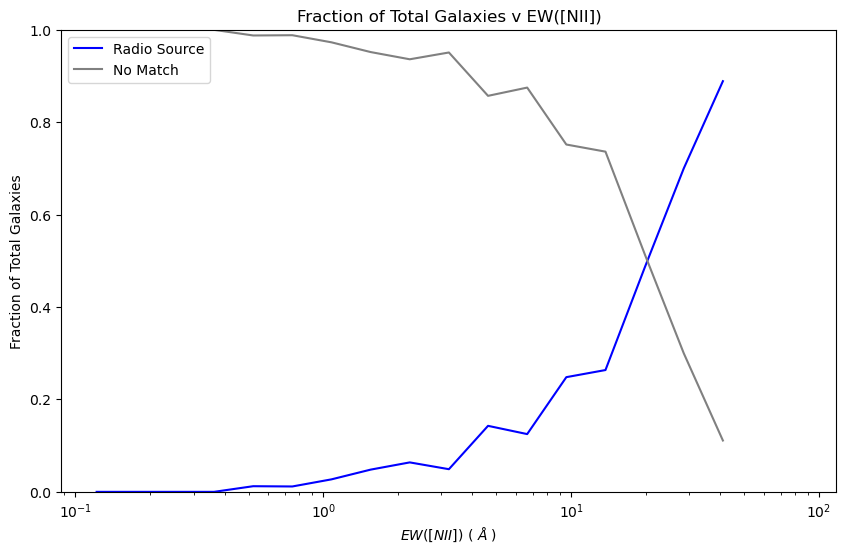

In [80]:
with fits.open(shared_catalogue_filepath + "HAlpha_EW_Table.fits") as Ha_EW_hdul:
    Ha_EW_table = Table(Ha_EW_hdul[1].data)

with fits.open( os.path.join(catalogue_filepath, SAMI_spectra_catalogue) ) as SAMI_spectra_hdul:
    SAMI_spectra_table_hdu = Table(SAMI_spectra_hdul[1].data)

with fits.open( os.path.join(shared_catalogue_filepath, "SAMI_AGN_matches.fits") ) as SAMI_AGN_matches_hdul:
    Summary_table_hdu = Table(SAMI_AGN_matches_hdul[1].data)

with fits.open( os.path.join(shared_catalogue_filepath, gassig_statistics_catalogue) ) as gassig_statistics_hdul:
    gassig_statistics_table_hdu = Table(gassig_statistics_hdul[1].data)


reduced_spectra_table = SAMI_spectra_table_hdu.copy()
reduced_spectra_table.keep_columns(['CATID', 'NII6583_1_4_ARCSECOND', 'NII6583_1_4_ARCSECOND_ERR', 'HALPHA_1_4_ARCSECOND', 'HALPHA_1_4_ARCSECOND_ERR'])
HA_EW_NII_HA_table = join(Ha_EW_table, reduced_spectra_table, keys='CATID', join_type='inner')
HA_EW_NII_HA_table = join(HA_EW_NII_HA_table, Summary_table_hdu['CATID', 'CATEGORY_BPT_AGN', 'IS_RADIOSOURCE', 'RACS_TOTALFLUX'], keys='CATID', join_type='left')

SN_lim=3
method = 'LineFit'

SN_mask = ((HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND'] / HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND_ERR'] > SN_lim) 
           & (HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND'] / HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND_ERR'] > SN_lim) 
           & (HA_EW_NII_HA_table[f'H_Alpha_EW_{method}'] / HA_EW_NII_HA_table[f'H_Alpha_EW_err_{method}'] > SN_lim) )

radiosource_mask = HA_EW_NII_HA_table['IS_RADIOSOURCE'] == 1

NII_EW = lambda x: x['NII6583_1_4_ARCSECOND'] / x['HALPHA_1_4_ARCSECOND'] * x[f'H_Alpha_EW_{method}']

plt.figure(figsize=(10, 6))
bins = np.logspace(-1, 2, 20)

source_type_dict = {'Radio Source': (radiosource_mask, 'o', 20, radiosource_colour),
                    'No Match': ( ~radiosource_mask, nosource_marker , 2, nosource_colour),}
total_counts, _ = np.histogram(NII_EW(HA_EW_NII_HA_table[SN_mask]), bins=bins)

for category, (mask, marker, size, colour) in source_type_dict.items():
    mask = mask & SN_mask
    category_counts, _ = np.histogram(NII_EW(HA_EW_NII_HA_table[mask]), bins=bins)
    plt.plot(bins[:-1]+np.diff(bins)/2, category_counts / total_counts, label=category, color=colour, linestyle='-')

plt.xscale('log')
plt.xlabel(r"$EW([NII])$ ( $\AA$ )")
plt.ylabel('Fraction of Total Galaxies')
plt.ylim((0,1))
plt.legend(title=None)
plt.title('Fraction of Total Galaxies v EW([NII])')
plt.show()


# EW(Ha) for Cubes

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                   50                                                  NAXIS2  =                   50                                                  NAXIS3  =                 2048                                                  EXTEND  =                    T                                                  WCSAXES =                    3 / Number of coordinate axes                      CRPIX1  =                 25.5 / Pixel coordinate of reference point            CRPIX2  =                 25.5 / Pixel coordinate of reference point            CRPIX3  =               1024.0 / Pixel coordinate of reference point            CDELT1  = -0.00013888888888889 / [deg] Coordinate increment at reference point  CDELT2  =  0.00013888888888889 / [deg] C

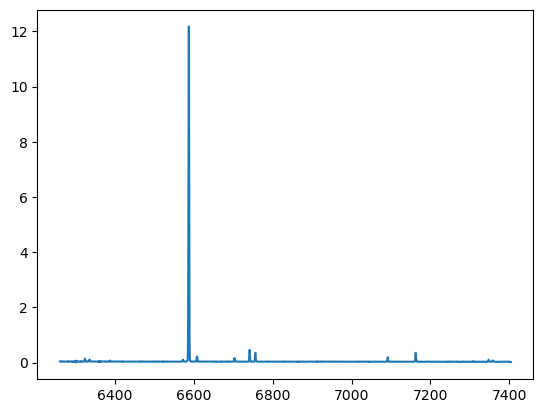

In [ ]:
refresh_module()
import EW_tools

test_CATID= CATIDs[3]



lam, flux, variance = EW_tools.read_cube(os.path.join(ifs_path, str(test_CATID), f"{test_CATID}_A_cube_red.fits.gz")
          )
# test_cube = fits.open(os.path.join(ifs_path, str(test_CATID), f"{test_CATID}_A_cube_red.fits.gz"))
# test_cube.info()

# cube_data = test_cube[0].data
# print(np.sum(np.isnan(cube_data[0])))

# plt.imshow(np.nansum(flux, axis=0), origin='lower')

plt.plot(lam, flux[:,24,24])



Continuum flux at Halpha: 0.008199970087353 +/- 0.0020451259689089865
0.009607309
Spaxel (16,16): EW = 1.1716272671574874, EW_err = 0.3908914145839946
Continuum flux at Halpha: 0.009013845241731357 +/- 0.0030797950464180107
0.010870889
Spaxel (16,17): EW = 1.206021241512153, EW_err = 0.5524768362973482
Continuum flux at Halpha: 0.01105837048740989 +/- 0.002524365861491928
0.0144177005
Spaxel (16,18): EW = 1.3037816453978115, EW_err = 0.42509657344579516
Continuum flux at Halpha: 0.011832246241358023 +/- 0.0020865196925952535
0.012217691
Spaxel (16,19): EW = 1.0325758033570798, EW_err = 0.2623666355597498
Continuum flux at Halpha: 0.012889772583644918 +/- 0.002237078322708898
0.015274974
Spaxel (16,20): EW = 1.1850460112526107, EW_err = 0.26505089645794816
Continuum flux at Halpha: 0.013468476427968733 +/- 0.0026801393199302765
0.020093007
Spaxel (16,21): EW = 1.491854488565346, EW_err = 0.3597433829268245
Continuum flux at Halpha: 0.01084097601646095 +/- 0.0023402145668766417
0.0168844

C:\Users\mspan\AppData\Local\Temp\ipykernel_10360\1775265162.py:102: RuntimeWarning: invalid value encountered in divide
  ha_ewsn = ha_ew / ha_ew_err
C:\Users\mspan\AppData\Local\Temp\ipykernel_10360\1775265162.py:106: RuntimeWarning: divide by zero encountered in log10
  vmin = np.log10( np.nanpercentile(ha_ew,5.0) )
C:\Users\mspan\AppData\Local\Temp\ipykernel_10360\1775265162.py:107: RuntimeWarning: divide by zero encountered in log10
  vmax = np.log10(np.nanpercentile(ha_ew,95.0))
C:\Users\mspan\AppData\Local\Temp\ipykernel_10360\1775265162.py:113: RuntimeWarning: divide by zero encountered in log10
  im_ha_ew = ax_ha_ew.imshow(np.log10(ha_ew_masked),origin='lower',interpolation='nearest',cmap=py.cm.YlOrRd,vmin=vmin,vmax=vmax)
C:\Users\mspan\AppData\Local\Temp\ipykernel_10360\1775265162.py:117: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
C:\Users\mspan\AppData\Local\Temp\ipykernel_10360\1775265162.py:136: RuntimeWarning: divide by zero en

<Axes: xlabel='log([NII]/Ha)', ylabel='log(EW(Ha))'>

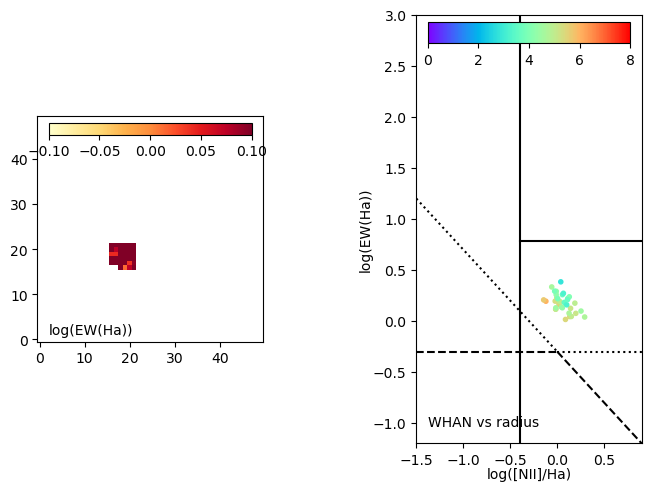

In [25]:
refresh_module()

def get_Halpha_EW_image(catid, ifs_path=ifs_path, estimation_method='median', haflux_masked=None, haerr=None, ha_SN_lim=3, redshift_spec=None, bin='default'):
    """Get the Halpha EW at each spaxel in the cube.
    Can take in a pre-masked Halpha flux array to avoid re-calculating the mask.
    Can take in a specific estimation method (e.g., 'median', 'mean') for the EW calculation.

    Returns Ha_EW_image, Ha_EW_err_image
    """

    # first read in the cube - check that this is alwats catid_A
    lam, flux, variance = EW_tools.read_cube(os.path.join(ifs_path, str(catid), f"{catid}_A_cube_red.fits.gz"))

    # redshift correct the wavelength array
    if redshift_spec is None:
        redshift_spec = all_fctns.get_z_best(catalogue_filepath, [catid], only_spec=True)
    
    lam = lam / (1 + redshift_spec)
    


    if haflux_masked is None:
        # copied from scotts original dr3_sov code:
        haflux_file = os.path.join(ifs_path, str(catid),str(catid)+'_A_Halpha_'+bin+'_1-comp.fits')
        haflux = fits.getdata(haflux_file, ext=0)[0,:,:]
        haerr =  fits.getdata(haflux_file, extname='HALPHA_ERR')[0,:,:]
        hasn = haflux/haerr
        ha_snflag = np.where((hasn > ha_SN_lim),0,1)
        haflux_masked = np.ma.masked_array(haflux,(ha_snflag>0))

    HAlpha_EW_image = np.zeros(haflux_masked.shape)
    HAlpha_EW_err_image = np.zeros(haflux_masked.shape)
    counter = 0

    # now iterate over each spaxel
    for i in range(haflux_masked.shape[0]):
        for j in range(haflux_masked.shape[1]):
            # if not (i in (16,17,18,19,20,21) and (j in (16,17,18,19,20,21))):
                # continue

            if not haflux_masked.mask[i,j]:
                # print(np.sum(~np.isnan(flux[:,i,j])))
                HAlpha_EW_image[i,j], HAlpha_EW_err_image[i,j] = EW_tools.get_Halpha_EW(catid, ifs_path=ifs_path, estimation_method=estimation_method, 
                                                                                sami_flux_red=flux[:,i,j], sami_lam_red=lam, already_zcorr=True,
                                                                                HAlpha_flux=haflux_masked[i,j], HAlpha_error=haerr[i,j])
            else:
                HAlpha_EW_image[i,j] = np.nan
                HAlpha_EW_err_image[i,j] = np.nan
            
            # print(f"Spaxel ({i},{j}): EW = {HAlpha_EW_image[i,j]}, EW_err = {HAlpha_EW_err_image[i,j]}")
            # EW_tools.get_Halpha_EW_spectra_investigation_plot(flux[:,i,j], lam, haflux_masked[i,j], haerr[i,j])

            if HAlpha_EW_image[i,j] > 0:
                counter += 1
                
    # print(f"Counter: {counter}")

    # print(np.sum(HAlpha_EW_image>0))

    return HAlpha_EW_image, HAlpha_EW_err_image


bin='default'


# plt.imshow(HAlpha_EW_image, origin='lower', vmin=0, vmax=50)

import pylab as py
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

snlim= 3

catid= CATIDs[2]

haflux_file = os.path.join(ifs_path, str(catid),str(catid)+'_A_Halpha_'+bin+'_1-comp.fits')
haflux = fits.getdata(haflux_file, ext=0)[0,:,:]
haerr =  fits.getdata(haflux_file, extname='HALPHA_ERR')[0,:,:]
hasn = haflux/haerr
ha_snflag = np.where((hasn > snlim),0,1)
haflux_masked = np.ma.masked_array(haflux,(ha_snflag>0))

n2flux_file = os.path.join(ifs_path, str(catid),str(catid)+'_A_NII6583_'+bin+'_1-comp.fits')
n2flux = fits.getdata(n2flux_file, ext=0)
n2err =  fits.getdata(n2flux_file, extname='NII6583_ERR')
n2sn = n2flux/n2err
n2ha = np.log10(n2flux/haflux)
n2ha_snflag = np.where(((hasn > snlim) & (n2sn > snlim)),0,1)
n2ha_masked = np.ma.masked_array(n2ha,(n2ha_snflag>0))


fig1 = py.figure(1,constrained_layout=True)
fig1.clf()
gs = fig1.add_gridspec(1, 2,wspace=0.3,hspace=0.3,top=0.95,bottom=0.1)



ax_ha_ew = fig1.add_subplot(gs[0,0]) # change this
ax_ha_ew.set_aspect('equal', 'box')

ha_ew, ha_ew_err= EW_tools.get_Halpha_EW_image(catid, estimation_method='median', bin=bin, haflux_masked=haflux_masked, haerr=haerr, ifs_path=ifs_path, catalogue_filepath=catalogue_filepath) # haflux_masked=haflux_masked, haerr=haerr, redshift=redshift

ha_ewsn = ha_ew / ha_ew_err
ha_ew_snflag = np.where((ha_ewsn > snlim),0,1)
ha_ew_masked = np.ma.masked_array(ha_ew,(ha_ew_snflag>0))

vmin = np.log10( np.nanpercentile(ha_ew,5.0) )
vmax = np.log10(np.nanpercentile(ha_ew,95.0))



print(vmin, vmax)

im_ha_ew = ax_ha_ew.imshow(np.log10(ha_ew_masked),origin='lower',interpolation='nearest',cmap=py.cm.YlOrRd,vmin=vmin,vmax=vmax)
axins_ha_ew = inset_axes(ax_ha_ew,width="90%",height="5%",loc='upper center')
fig1.colorbar(im_ha_ew, cax=axins_ha_ew, orientation="horizontal")
ax_ha_ew.text(0.05, 0.05,'log(EW(Ha))', horizontalalignment='left',verticalalignment='center', transform=ax_ha_ew.transAxes)
fig1.show()



# plot WHaN diagram
snflag = np.where(((hasn > snlim) & (n2sn > snlim) & (ha_ewsn > snlim)),0,1)
            
ha_ew_masked = np.ma.masked_array(ha_ew,(snflag>0))
n2ha_masked = np.ma.masked_array(n2ha,(snflag>0))

# set up grid to get distance from centre (in arcsec):
x = y = np.arange(0.0,50.0,1.0)
X, Y = np.meshgrid(x, y)
xcent = 25.0
ycent = 25.0
rdist = np.sqrt((X-xcent)**2 + (Y-ycent)**2)/2.0

# ax_whan = fig1.add_subplot(gs[3,3])
ax_whan = fig1.add_subplot(gs[0,1])
im_whan = ax_whan.scatter(n2ha_masked,np.log10(ha_ew_masked),c=rdist,marker='.',vmin=0.0,vmax=8.0,cmap=py.cm.rainbow)
ax_whan.text(0.05, 0.05,'WHAN vs radius', horizontalalignment='left',verticalalignment='center', transform=ax_whan.transAxes)
ax_whan.xaxis.labelpad=0
ax_whan.yaxis.labelpad=0



axins_whan = inset_axes(ax_whan,width="90%",height="5%",loc='upper center')
fig1.colorbar(im_whan, cax=axins_whan, orientation="horizontal")

ax_whan.set(xlim=[-1.5,0.9],ylim=[-1.2,3],xlabel='log([NII]/Ha)',ylabel='log(EW(Ha))')
# plot WHAN lines:
EW_tools.plot_WHAN_lines(ax_whan, fontsize=10, region_labels=False)


In [34]:
refresh_module()
test_CATID = CATIDs[0]

sami_flux_red, sami_lam_red_zcorr = get_redshift_corrected_spectra(test_CATID)
HAlpha_flux, HAlpha_error = all_fctns.get_flux_and_error_1_4_ARCSEC(SAMI_spectra_table_hdu[SAMI_spectra_table_hdu['CATID'] == test_CATID], 'H Alpha')

EW_tools.get_Halpha_EW_spectra_investigation_plot(sami_flux_red, sami_lam_red_zcorr, HAlpha_flux, HAlpha_error)


NameError: name 'SAMI_spectra_table_hdu' is not defined

# O III EW

[4877. 4937.] [5077. 5137.]
Region 1 flux: 0.24 +/- 0.02


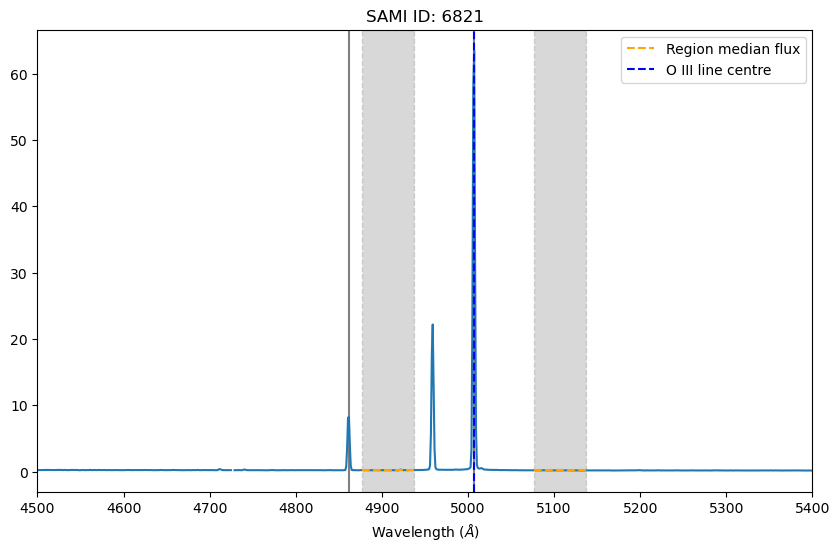

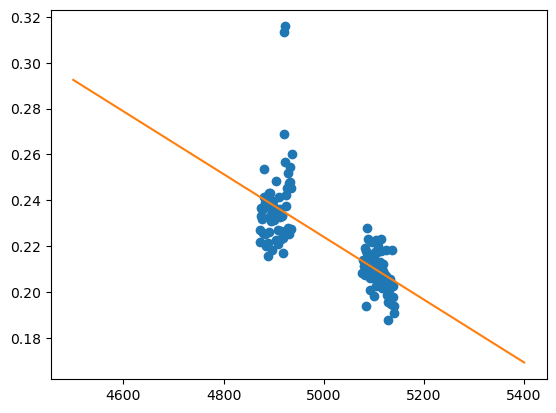

In [43]:
import EW_tools
refresh_module()
CATID = CATIDs[3]

fig, ax = plt.subplots(1,1, figsize=(10,6))

sami_flux_blue, sami_lam_blue_zcorr = EW_tools.get_redshift_corrected_spectra(CATID, ifs_path=ifs_path, catalogue_filepath=catalogue_filepath, spectra_type='blue')
ax.plot(sami_lam_blue_zcorr, sami_flux_blue)
plot_tools.plot_line_lam(ax, z=0, annotations=False)
ax.set_title(f"SAMI ID: {CATID}")
ax.set_xlabel(r"Wavelength ($\AA$)")
ax.set_xlim(4000,6000)


# set regions for collecting continuum flux symmetric about 6562
region_width = 60
region_separation = 140
O3_lam = 5007
region1 = np.array([-region_width, 0]) + O3_lam - region_separation/2  
region2 = np.array([0, region_width]) + O3_lam + region_separation/2  
print(region1, region2)

# plot these regions
ax.axvspan(region1[0], region1[1], color='grey', alpha=0.3, linestyle='--')
ax.axvspan(region2[0], region2[1], color='grey', alpha=0.3, linestyle='--')


def get_spectra_region_flux(sami_lam, sami_flux, region, estimation_method='median'):
    """Get the mean flux in a given wavelength region."""
    region_mask = (sami_lam >= region[0]) & (sami_lam <= region[1])
    region_flux = np.mean(sami_flux[region_mask])
    region_flux_err = np.std(sami_flux[region_mask]) # check this
    return region_flux, region_flux_err

region1_flux, region1_flux_err = get_spectra_region_flux(sami_lam_blue_zcorr, sami_flux_blue, region1)
region2_flux, region2_flux_err = get_spectra_region_flux(sami_lam_blue_zcorr, sami_flux_blue, region2)
print(f"Region 1 flux: {region1_flux:.2f} +/- {region1_flux_err:.2f}")

ax.plot(region1, [region1_flux]*2, color='orange', linestyle='--', label='Region median flux')
ax.plot(region2, [region2_flux]*2, color='orange', linestyle='--')

ax.axvline(O3_lam, color='blue', linestyle='--', label='O III line centre')
ax.legend()

ax.set_xlim(4500, 5400)
# plt.ylim(0, 0.4)

plt.show()

plt.figure()

region_width = 65
region_separation = 140
O3_lam = 5007
region1 = np.array([-region_width, 0]) + O3_lam - region_separation/2  
region2 = np.array([0, region_width]) + O3_lam + region_separation/2  
regions = (region1, region2)

# get the relevant points for line fitting
regions_mask = (sami_lam_blue_zcorr >= regions[0][0]) & (sami_lam_blue_zcorr <= regions[0][1]) | (sami_lam_blue_zcorr >= regions[1][0]) & (sami_lam_blue_zcorr <= regions[1][1])
regions_sami_lam_blue_zcorr = sami_lam_blue_zcorr[regions_mask]
regions_sami_flux_blue = sami_flux_blue[regions_mask]

plt.plot(regions_sami_lam_blue_zcorr, regions_sami_flux_blue, 'o')

# fit a line to these points
res = sp.stats.linregress(regions_sami_lam_blue_zcorr, regions_sami_flux_blue)
slope, intercept, slope_err, intercept_err = res.slope, res.intercept, res.stderr, res.intercept_stderr
continuum_flux = slope*O3_lam + intercept
continuum_flux_err = np.sqrt( (slope_err*O3_lam)**2 + intercept_err**2 )
lambda_fit = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 1000)
plt.plot(lambda_fit, slope*lambda_fit + intercept, label='Linear fit to continuum regions')

In [71]:
refresh_module()
print(ifs_path)
EW_tools.get_EW(CATIDs[0], em_line='O III', ifs_path=ifs_path, catalogue_filepath=catalogue_filepath)

EW_tools.get_EW_table(CATIDs, em_line='O III', ifs_path=ifs_path, catalogue_filepath=catalogue_filepath)


C:\Users\mspan\OneDrive - The University of Sydney (Students)\Honours\Honours Project\sami_tools_smc_mspa4681\some_sample_ifs\
CATID 40916: Continuum flux at O III (median): 0.1984726110687294 +/- 0.01578051008438834
CATID 40916: Continuum flux at O III (median): 0.1984726110687294 +/- 0.01578051008438834
CATID 40916: Continuum flux at O III (linefit): 0.19860899603948126 +/- 0.07243158349700317
CATID 9011900711: Continuum flux at O III (median): 0.5884491670845368 +/- 0.03361604893933316
CATID 9011900711: Continuum flux at O III (linefit): 0.5870185459701351 +/- 0.15884142706420729
CATID 298590: Continuum flux at O III (median): 0.8396289815235891 +/- 0.04715385616788976
CATID 298590: Continuum flux at O III (linefit): 0.8380961348041525 +/- 0.22192761987611365
CATID 6821: Continuum flux at O III (median): 0.22186739036503733 +/- 0.01928477905844786
CATID 6821: Continuum flux at O III (linefit): 0.22393151078627804 +/- 0.09617032264231341


CATID,O_III_EW_MedianFit,O_III_EW_err_MedianFit,O_III_EW_LineFit,O_III_EW_err_LineFit
int64,float64,float64,float64,float64
40916,0.6579865891110831,0.10401394849805531,0.6575347491466276,0.25607512978641805
9011900711,0.03017448896400994,0.04672651373520991,0.03024802711936217,0.04751870777658483
298590,2.051020441948988,0.12404372994446378,2.0547716822010074,0.5460538599509112
6821,877.7566393635312,76.30113627611833,869.6657932033448,373.49063200485165
